In [1]:
import torch 
import numpy as np
import pandas as pd 
import utilities
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
from torch.autograd import Variable

In [69]:
fin_df = pd.read_csv("Datasets/sp500_sentiment_non_weighted.csv")
fin_df

,Unnamed: 0,date,Volume,Close,Positive,Negative,Neutral,Price_change
0,0,2010-01-05,1.111477e+07,1136.520020,0.157785,0.489590,0.352625,1
1,1,2010-01-06,9.592200e+06,1137.140015,0.159253,0.114102,0.726645,1
2,2,2010-01-07,1.264640e+07,1141.689941,0.441000,0.012006,0.546994,1
3,3,2010-01-08,1.508503e+07,1144.979980,0.039152,0.384472,0.576376,1
4,4,2010-01-11,7.396000e+06,1146.979980,0.114053,0.029774,0.856173,1
...,...,...,...,...,...,...,...,...
2603,2603,2020-06-05,2.503270e+07,3193.929932,0.567891,0.070503,0.361606,1
2604,2604,2020-06-08,2.303770e+07,3232.389893,0.523481,0.124646,0.351873,1
2605,2605,2020-06-09,2.969893e+07,3207.179932,0.296441,0.337487,0.366072,-1
2606,2606,2020-06-10,3.795272e+07,3190.139893,0.390972,0.240399,0.368628,-1


### Pre-process dataset
Create small time series of 30 days. So for every 30 days' close prices $X_{it}$ we have a label price $y_t$ which is the closing price of 31st day.

In [3]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((fin_df.shape[0] - seq_len, seq_len))
y = np.zeros((fin_df.shape[0] - seq_len, 1))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (2607, 1)
y shape : (2607, 1)


In [4]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = fin_df.iloc[i-seq_len : i]['Close']
    # only the desired values
    prev_elems = [ p for p in prev_elems]
    prev_elems = np.array(prev_elems)
    # Store previous 30 days close price
    X[i-seq_len] = prev_elems
    # Store label, close price of day 31 
    y[i-seq_len] = fin_df.iloc[i]['Close']

### Normalise dataset and split into train-test.
Min - Max scaling 

In [5]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(np.array(y).reshape(-1, 1))

Data splitting into train, test . 

### Convert np.arrays into tensors and reshape in the format expected by the LSTM .

In [6]:
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y_mm))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))


In [28]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(y)

# fraction of the test set.
percentage = 0.3
split_tr = ceil(X_mm.shape[0] *(1-percentage))
split_val = ceil(X_mm.shape[0] *(1- percentage/2))

X_train = X_mm[0:split_tr]
y_train = y_mm[0:split_tr]
X_val= X_mm[split_tr: split_val]
y_val= y_mm[split_tr: split_val]
X_test= X_mm[split_val:]
y_test= y_mm[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

### TO tensors 
###
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
X_val_tensors = Variable(torch.Tensor(X_val))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
y_val_tensors = Variable(torch.Tensor(y_val))



Train data shapes X:(1825, 1) , y:(1825, 1)
Test data shapes X:(391, 1) , y:(391, 1)
Val data shapes X:(391, 1) , y:(391, 1)


In [29]:
#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
print("Validation Shape", X_val_tensors_final.shape, y_val_tensors.shape)

Training Shape torch.Size([1825, 1, 1]) torch.Size([1825, 1])
Testing Shape torch.Size([391, 1, 1]) torch.Size([391, 1])
Validation Shape torch.Size([391, 1, 1]) torch.Size([391, 1])


### Define LSTM structure .
The LSTM will execute regression, so MSE loss is need during training. 

In [30]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.2, fc_size=128):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=dropout) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size * num_layers, fc_size) #fully connected 1
        self.fc = nn.Linear(fc_size, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size * num_layers) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [46]:
#hyperparameters
num_epochs = 5000 #1000 epochs
learning_rate = 0.003 #0.001 lr

input_size = seq_len #number of features
hidden_size = 5 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, dropout=0.4, fc_size=128) #our lstm class

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

C:\Users\Konpoul\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


#### Training loop

In [47]:
plot_loss_tr = []
plot_loss_val = []
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    plot_loss_tr.append(loss.item())
    loss.backward() #calculates the loss of the loss function

    # Compute validation loss
    val_outs = lstm1.forward(X_val_tensors_final) #forward pass
    val_loss = criterion(val_outs, y_val_tensors)
    plot_loss_val.append(val_loss.item())

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, loss.item(), val_loss.item()))

Epoch: 0, train_loss: 0.22292,  val_loss: 0.74330 
Epoch: 100, train_loss: 0.00359,  val_loss: 0.04020 
Epoch: 200, train_loss: 0.00004,  val_loss: 0.00607 
Epoch: 300, train_loss: 0.00004,  val_loss: 0.00590 
Epoch: 400, train_loss: 0.00004,  val_loss: 0.00568 
Epoch: 500, train_loss: 0.00004,  val_loss: 0.00559 
Epoch: 600, train_loss: 0.00004,  val_loss: 0.00562 
Epoch: 700, train_loss: 0.00004,  val_loss: 0.00559 
Epoch: 800, train_loss: 0.00004,  val_loss: 0.00557 
Epoch: 900, train_loss: 0.00004,  val_loss: 0.00556 
Epoch: 1000, train_loss: 0.00004,  val_loss: 0.00555 
Epoch: 1100, train_loss: 0.00004,  val_loss: 0.00555 
Epoch: 1200, train_loss: 0.00004,  val_loss: 0.00554 
Epoch: 1300, train_loss: 0.00004,  val_loss: 0.00554 
Epoch: 1400, train_loss: 0.00004,  val_loss: 0.00556 
Epoch: 1500, train_loss: 0.00004,  val_loss: 0.00557 
Epoch: 1600, train_loss: 0.00004,  val_loss: 0.00557 
Epoch: 1700, train_loss: 0.00004,  val_loss: 0.00557 
Epoch: 1800, train_loss: 0.00004,  val_l

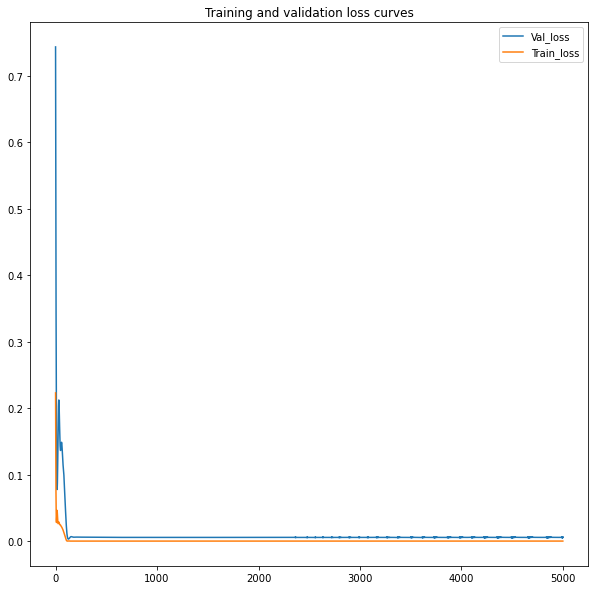

In [48]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(plot_loss_val, label='Val_loss') #actual plot
plt.plot(plot_loss_tr, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.legend()
plt.show()

### Predicting with the LSTM

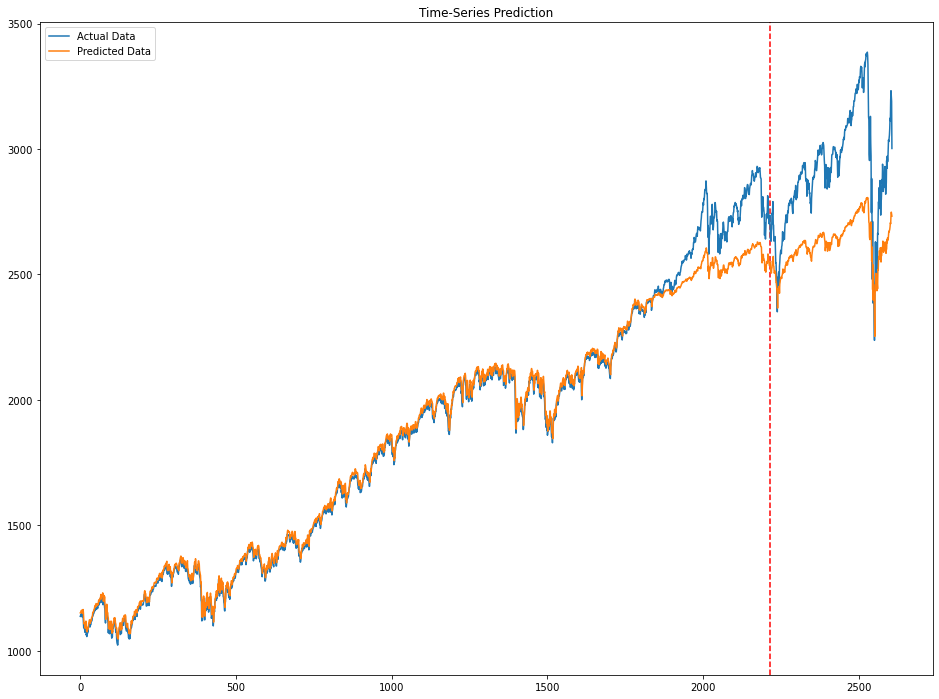

In [49]:
train_predict = lstm1(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors.data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

data_predict = mm.inverse_transform(data_predict) #reverse transformation
#dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(16,12)) #plotting
plt.axvline(x=split_val, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

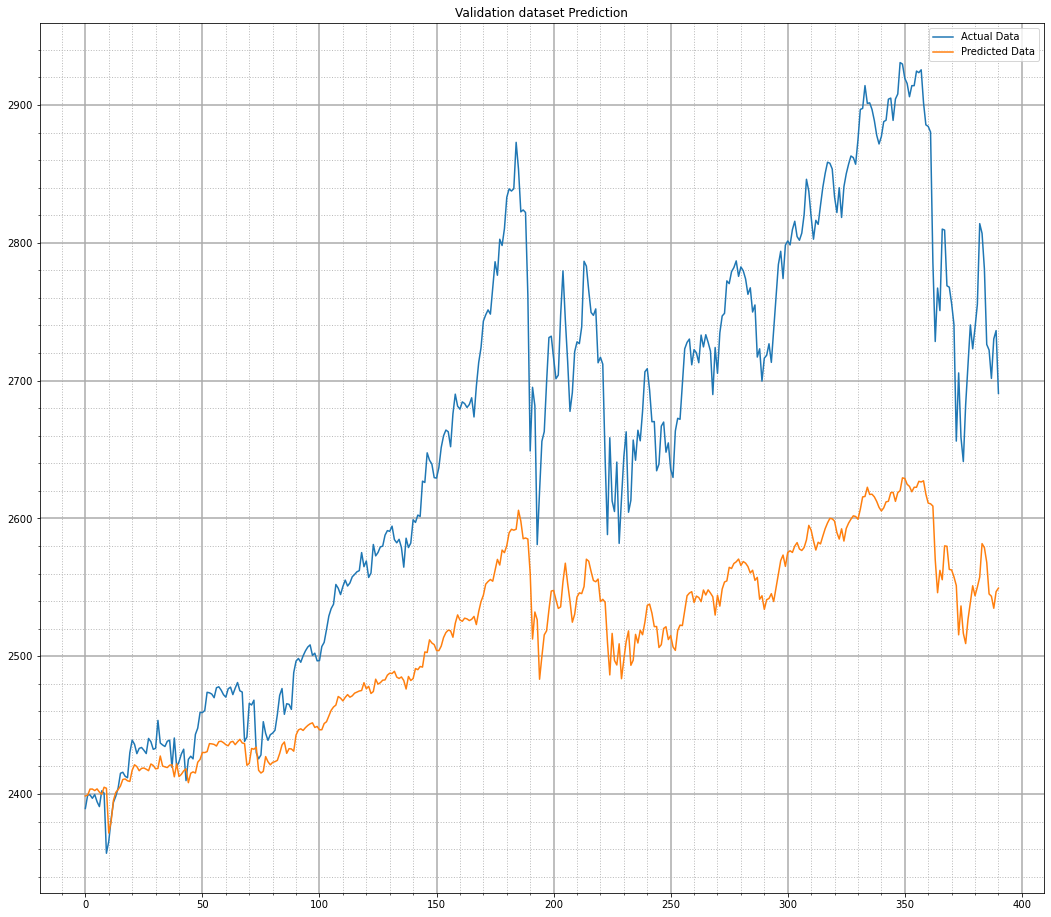

In [62]:
train_predict = lstm1(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors.data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

data_predict = mm.inverse_transform(data_predict) #reverse transformation
#dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(18,16)) #plotting

plt.plot(dataY_plot[split_tr:split_val], label='Actual Data') #actual plot
plt.plot(data_predict[split_tr:split_val], label='Predicted Data') #predicted plot
plt.title('Validation dataset Prediction')
plt.legend()

# Show the major grid and style it slightly.
plt.grid(which='major', color='#AAA', linewidth=1.5)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='#BBB', linestyle=':', linewidth=1)
# Make the minor ticks and gridlines show.
plt.minorticks_on()

plt.show()

### Evaluation of regression predictions with MSE and Spearman Correlation. 

In [54]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[ : split_tr] - data_predict[ : split_tr], 2).mean())
print("TRAIN DATA , MSE loss : ", mse)

mse = (np.power(dataY_plot[split_tr : split_val] - data_predict[split_tr : split_val], 2).mean())
print("VALIDATION DATA , MSE loss : ", mse)

TRAIN DATA , MSE loss :  432.15842
VALIDATION DATA , MSE loss :  27523.016


In [56]:
from scipy.stats import spearmanr, pearsonr
#from sklearn.metric import mean_squared_error
spearman1 = spearmanr(dataY_plot[split_tr : split_val], data_predict[split_tr : split_val])
print("Val DATA,  Spreaman correlation : ", spearman1)
pearson1, p1  = pearsonr(np.squeeze(dataY_plot[split_tr : split_val]), np.squeeze(data_predict[split_tr : split_val]))
print("Val DATA,  Pearson correlation=", pearson1, ", pvalue=",p1)
print()

spearman2 = spearmanr(dataY_plot[:split_tr],data_predict[:split_tr])
print("TRAIN DATA , Spreaman correlation : ", spearman2)
pearson2, p2= pearsonr(np.squeeze(dataY_plot[:split_tr]), np.squeeze(data_predict[:split_tr]))
print("TRAIN DATA,  Pearson correlation=", pearson2, ", pvalue=",p2)

Val DATA,  Spreaman correlation :  SpearmanrResult(correlation=0.9865314326127976, pvalue=5.560591589996609e-308)
Val DATA,  Pearson correlation= 0.9904453277671009 , pvalue= 0.0

TRAIN DATA , Spreaman correlation :  SpearmanrResult(correlation=0.9982099599914334, pvalue=0.0)
TRAIN DATA,  Pearson correlation= 0.9992656118187304 , pvalue= 0.0


### TEST SET EVALUATION

In [59]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_val:] - data_predict[split_val:], 2).mean())
print("TEST DATA, MSE loss : ", mse)

#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[split_val:], data_predict[split_val:] )
print("TEST DATA , Spreaman correlation : ", spearman)
pearson3, p3= pearsonr(np.squeeze(dataY_plot[:split_tr]), np.squeeze(data_predict[:split_tr]))
print("TEST DATA,  Pearson correlation=", pearson3, ", pvalue=",p3)

TEST DATA, MSE loss :  103030.47
TEST DATA , Spreaman correlation :  SpearmanrResult(correlation=0.9791424575658816, pvalue=2.3837444141283244e-271)
TEST DATA,  Pearson correlation= 0.9992656118187304 , pvalue= 0.0


# 2.) Classification of price movement with LSTM 

## Pre-process dataset


### Price_change is the class . 0: decrease , +1 : increase

In [70]:
fin_df = pd.read_csv('Datasets/nvidia_fin_2_labels.csv')

In [71]:
fin_df['Price_change'] = fin_df['Price_change'].apply(lambda x : x+1 if (x==-1) else x)
fin_df

,Date,Open,Close,Volume,Price_change,date
0,2008-01-31,6.160000,6.147500,58870800,1,0
1,2008-02-01,6.135000,6.715000,59310400,1,2008-02-01
2,2008-02-04,6.860000,6.505000,56512800,0,2008-02-04
3,2008-02-05,6.375000,6.097500,49492800,0,2008-02-05
4,2008-02-06,6.162500,6.077500,55738000,0,2008-02-06
...,...,...,...,...,...,...
3114,2020-06-15,88.152496,91.737503,40000400,1,2020-06-15
3115,2020-06-16,92.250000,90.684998,53571600,0,2020-06-16
3116,2020-06-17,91.137497,92.360001,40830400,1,2020-06-17
3117,2020-06-18,92.269997,92.180000,25440800,0,2020-06-18


Create small time series of N days. So for every N days' close prices $X_{it}$ we have a label price $y_t$ which is the price movement compared to yesterday (increase or decrease in price).

In [72]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((fin_df.shape[0] - seq_len, seq_len))
y = np.zeros((fin_df.shape[0] - seq_len, 1))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (3118, 1)
y shape : (3118, 1)


In [73]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = fin_df.iloc[i-seq_len : i]['Close']
    # only the desired values
    prev_elems = [p for p in prev_elems]
    prev_elems = np.array(prev_elems)
    # Store previous seq_len  days close price
    X[i-seq_len] = prev_elems
    # Store label, close price of day 31 
    y[i-seq_len] = fin_df.iloc[i]['Price_change']

### Normalise dataset and split into train-test-val.
#### Convert np.arrays into tensors and reshape in the format expected by the LSTM .
Min - Max scaling 

In [74]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()

X_mm = mm.fit_transform(X)

# fraction of the test set.
percentage = 0.4
split_tr = ceil(X_mm.shape[0] *(1-percentage))
split_val = ceil(X_mm.shape[0] *(1- percentage/2))

X_train = X_mm[0:split_tr]
y_train = y[0:split_tr]
X_val= X_mm[split_tr: split_val]
y_val= y[split_tr: split_val]
X_test= X_mm[split_val:]
y_test= y[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

### TO tensors 
###
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
X_val_tensors = Variable(torch.Tensor(X_val))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
y_val_tensors = Variable(torch.Tensor(y_val))

#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
print("Validation Shape", X_val_tensors_final.shape, y_val_tensors.shape)

Train data shapes X:(1871, 1) , y:(1871, 1)
Test data shapes X:(623, 1) , y:(623, 1)
Val data shapes X:(624, 1) , y:(624, 1)
Training Shape torch.Size([1871, 1, 1]) torch.Size([1871, 1])
Testing Shape torch.Size([623, 1, 1]) torch.Size([623, 1])
Validation Shape torch.Size([624, 1, 1]) torch.Size([624, 1])


In [75]:
y_train_tensors.shape

torch.Size([1871, 1])

### Define classification LSTM  : We need to add a sigmoid activation function at the end in order to get output in the $[0,1]$ range.

In [76]:
class LSTM_clf(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size=128):
        super(LSTM_clf, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) #lstm
        
        self.dropout = nn.Dropout(p=dropout)
        self.fc_1 =  nn.Linear(hidden_size * num_layers, fc_size) #fully connected 1
        self.fc = nn.Linear(fc_size, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        # sigmoid activation for end classification
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size * num_layers) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.dropout(out) 
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        
        out = self.sigm(out)
        return out

In [77]:
X_train_tensors_final.shape[1]

1

#### Training the LSTM . 

In [92]:
#hyperparameters
num_epochs = 1000 #1000 epochs
learning_rate = 0.0001 
input_size = 1 #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

lstm_clf = LSTM_clf(num_classes, input_size, hidden_size, num_layers,  dropout=0.4, fc_size=128) #our lstm network 

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_clf.parameters(), lr=learning_rate)

#### TRAIN LOOP #####
plot_loss_tr = []
plot_loss_val = []
for epoch in tqdm(range(num_epochs)):
  outputs = lstm_clf.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
  plot_loss_tr.append(loss.item())
  loss.backward() #calculates the loss of the loss function
  
  # Compute validation loss
  val_outs = lstm_clf.forward(X_val_tensors_final) #forward pass
  val_loss = criterion(val_outs, y_val_tensors)
  plot_loss_val.append(val_loss.item())

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, loss.item(), val_loss.item()))

C:\Users\Konpoul\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|▋                                                                                | 9/1000 [00:00<00:24, 41.27it/s]

Epoch: 0, train_loss: 0.25004,  val_loss: 0.24947 


 10%|████████▎                                                                      | 105/1000 [00:02<00:17, 52.58it/s]

Epoch: 100, train_loss: 0.25036,  val_loss: 0.25073 


 21%|████████████████▎                                                              | 207/1000 [00:04<00:16, 47.15it/s]

Epoch: 200, train_loss: 0.24994,  val_loss: 0.25006 


 31%|████████████████████████▏                                                      | 306/1000 [00:06<00:12, 54.72it/s]

Epoch: 300, train_loss: 0.25009,  val_loss: 0.25038 


 41%|████████████████████████████████▏                                              | 408/1000 [00:07<00:10, 54.10it/s]

Epoch: 400, train_loss: 0.25007,  val_loss: 0.25055 


 51%|████████████████████████████████████████▎                                      | 511/1000 [00:09<00:08, 56.08it/s]

Epoch: 500, train_loss: 0.25008,  val_loss: 0.25087 


 61%|████████████████████████████████████████████████                               | 609/1000 [00:11<00:06, 56.96it/s]

Epoch: 600, train_loss: 0.24997,  val_loss: 0.25089 


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [00:13<00:05, 55.21it/s]

Epoch: 700, train_loss: 0.25013,  val_loss: 0.25090 


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [00:15<00:04, 41.92it/s]

Epoch: 800, train_loss: 0.24997,  val_loss: 0.25053 


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [00:17<00:01, 49.63it/s]

Epoch: 900, train_loss: 0.24998,  val_loss: 0.25067 


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.82it/s]


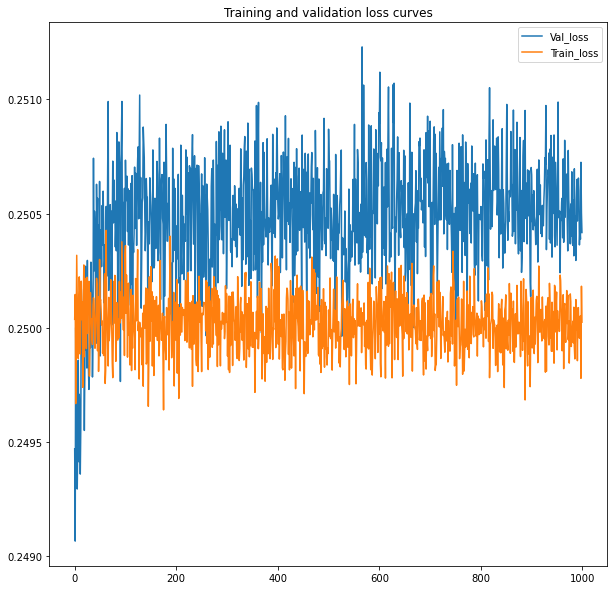

In [93]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(plot_loss_val, label='Val_loss') #actual plot
plt.plot(plot_loss_tr, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.legend()
plt.show()

### Prediction and evaluation of LSTM classifier .

In [94]:
train_predict = lstm_clf(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
predictions = np.argmax(data_predict, axis=1)

In [95]:
from sklearn.metrics import accuracy_score

#from sklearn.metric import mean_squared_error
acc = accuracy_score(y[:split_tr], predictions[:split_tr])
print("TRAIN DATA , accuracy : ", round(acc,6))

acc = accuracy_score(y[split_tr : split_val], predictions[split_tr : split_val])
print("VAL DATA, accuracy : ", round(acc,6))

TRAIN DATA , accuracy :  0.50294
VAL DATA, accuracy :  0.432692


In [96]:
# Number of increase predictions 
#print("Number of increase label predictions :",predictions[predictions[:,0] == 1].shape)
#print("Number of decrease label predictions :",predictions[predictions[:,1] == 1].shape)
#print("Overall data dataset shape : ",predictions.shape)

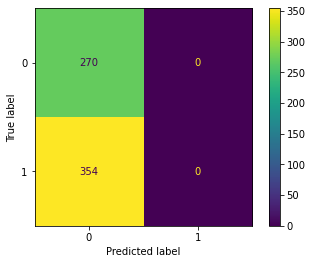

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y[split_tr : split_val] , predictions[split_tr : split_val], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=[0,1])
disp.plot()
plt.show()

#### TEST EVALUATION

TEST DATA, accuracy :  0.467095


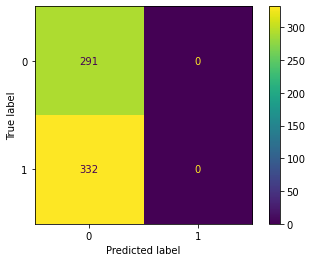

In [98]:
acc = accuracy_score(y[split_val:], predictions[split_val:])
print("TEST DATA, accuracy : ", round(acc,6))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y[split_val:] , predictions[split_val:], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=[0,1])
disp.plot()
plt.show()